In [1]:
import pandas as pd 
import pickle5 as pickle
import spacy
import plotly.express as px
from nltk.util import ngrams
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline
nlp = spacy.load('pl_spacy_model_morfeusz')
#https://github.com/ipipan/spacy-pl


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from operator import itemgetter
import numpy as np
from PIL import Image
from wordcloud import WordCloud 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
with open("./data/clean_data_with_opis_clean2021_01_05_17_26_25.pkl", "rb") as fh:
  data = pickle.load(fh)

In [4]:
def flatten(A):
    rt = list()
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return list(filter(None, rt))

def get_n_grams(df, field_name):
    total_doc=list()
    for token in df[field_name]:
        total_doc.append(token)
    total_doc=flatten(total_doc)
    # extracting n-grams
    unigrams = ngrams(total_doc, 1)
    bigrams = ngrams(total_doc, 2)
    trigrams = ngrams(total_doc, 3)
    # getting dictionary of all n-grams for corpus
    gram_dict = {
        "Unigram": unigrams,
        "Bigram": bigrams,
        "Trigram":trigrams}
    return total_doc,gram_dict

def spacy_tokenizer_lemmatizer(text):
    doc = nlp(text)
    lemma_list = []
    for token in doc:
        if token.is_stop is False and token.like_num is False and token.pos_!="X" and token.pos_!="PUNCT" and token.lemma_ != '' and len(token)>4:
            lemma_list.append(token.lemma_.lower())
    return lemma_list
    
def get_df_grams(gram_dict,ngram):    
    df=pd.Series(gram_dict[ngram]).value_counts()[:25].to_frame()
    df.reset_index(inplace=True)
    df.rename(columns={"index": ngram, 0: "freq"},inplace=True)
    df[ngram]=df[ngram].astype(str).replace(r"[,()']", '', regex=True)
    return df

#Helper to add real state stop words to the general list
def assing_stopwords(df):
    total_doc, gram_dict=get_n_grams(df,"opis_clean")
    df_unigram=get_df_grams(gram_dict,"Unigram")
    real_estate_stopwords=set(df_unigram['Unigram'][:25])
    nlp.Defaults.stop_words|=real_estate_stopwords
    return nlp.Defaults.stop_words
## removing stop words 
def real_estate_stopwords(text):
    return [word for word in text if word not in nlp.Defaults.stop_words]
 # proper data type
def repair_opis(text):
    return flatten(text.split(", "))


def create_plot(df, field_name,text):
    fig = px.bar(df, x=field_name, y='freq')
    fig.update_layout(
            height=400,
            width=1800,
            hovermode='x',
            plot_bgcolor='#efefef',
            paper_bgcolor='#efefef',
            title={
                'text': text,
                'y': 0.96,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
      )
    return fig


def plot_cloud(text):
    # Generate wordcloud
    plt.figure(figsize=(20, 15))
    mask = np.array(Image.open("./pictures/simple-house-exterior-white-background_1308-50195.jpg"))
    wordcloud = WordCloud(height=450, width=1000, random_state=1, background_color='black', colormap='Set2', collocations=False,mask=mask).generate(text)
    # Plot
    plt.imshow(wordcloud)
    plt.axis("off");
    #plot_cloud(wordcloud)
    
def repair_opis_for_nlp(text):
    return " ".join(text)


def create_tf_idf_scores(data):
    tfidfvectorizer = TfidfVectorizer(min_df=0.02, max_df=.90)
    tfidf_wm = tfidfvectorizer.fit_transform(data)
    return sorted(zip( tfidfvectorizer.get_feature_names(),tfidfvectorizer.idf_), key=itemgetter(1), reverse=True)

In [5]:
total_doc, gram_dict=get_n_grams(data,"opis_clean")
df_unigram=get_df_grams(gram_dict,"Unigram")
create_plot(df_unigram,"Unigram","Most Common Words - Unigram")

In [6]:
total_doc, gram_dict=get_n_grams(data,"opis_clean")
df_bigram=get_df_grams(gram_dict,"Bigram")
create_plot(df_bigram,"Bigram","Most Common Words - Bigram")


In [7]:
total_doc, gram_dict=get_n_grams(data,"opis_clean")
df_trigram=get_df_grams(gram_dict,"Trigram")
create_plot(df_trigram,"Trigram","Most Common Words - Trigram")

In [8]:
assing_stopwords(data)
data['opis_cleanv2']=data['opis_clean'].progress_apply(lambda x: real_estate_stopwords(x))
#data['opis_clean']=data['opis_clean'].progress_apply(lambda x: repair_opis(x))

100%|██████████| 39812/39812 [00:00<00:00, 84169.59it/s]


In [9]:
total_doc, gram_dict=get_n_grams(data,"opis_cleanv2")
df_unigram=get_df_grams(gram_dict,"Unigram")
create_plot(df_unigram,"Unigram","Most Common Words - Unigram - Common Real Estate Terms Removed")

In [10]:
total_doc, gram_dict=get_n_grams(data,"opis_cleanv2")
df_bigram=get_df_grams(gram_dict,"Bigram")
create_plot(df_bigram,"Bigram","Most Common Words - Bigram - Common Real Estate Terms Removed")

In [11]:
total_doc, gram_dict=get_n_grams(data,"opis_cleanv2")
df_trigram=get_df_grams(gram_dict,"Trigram")
create_plot(df_trigram,"Trigram","Most Common Words - Trigram - Common Real Estate Terms Removed")

In [12]:
data.head()

opis     cena data dodania  \
0  Na sprzedaż piękne 4 pokojowe mieszkanie o met...  1400000   2020-12-26   
1  Ustawne 4-pokojowe mieszkanie położone na 2 pi...   925000   2020-12-26   
2  Szukasz lokum blisko Centrum Warszawy z dużym ...   499000   2020-12-26   
3  ___________________English Version below______...  2599000   2020-12-26   
4  Na sprzedaż fajne dwupokojowe mieszkanie (z mo...   575000   2020-12-26   

             lokalizacja Na_sprzedaż_przez Rodzaj_nieruchomosci  \
0  Śródmieście, Warszawa           Agencja           Mieszkanie   
1      Ursynów, Warszawa           Agencja           Mieszkanie   
2  Śródmieście, Warszawa           Agencja           Mieszkanie   
3      Ursynów, Warszawa           Agencja                  Dom   
4         Wola, Warszawa           Agencja           Mieszkanie   

         Liczba_pokoi        Liczba_łazienek  Wielkość (m2) Parking  \
0            4 pokoje             1 łazienka            101   Ulica   
1            4 pokoje                    NaN             94     NaN   
2            2 pokoje             1 łazienka             48   Ulica   
3  6 lub więcej pokoi  4 lub więcej łazienek            390     NaN   
4            3 pokoje             1 łazienka             51   Ulica   

                                      mieszkanie_url    dzielnica    miasto  \
0  https://www.gumtree.pl/a-mieszkania-i-domy-spr...  Śródmieście  Warszawa   
1  https://www.gumtree.pl/a-mieszkania-i-domy-spr...      Ursynów  Warszawa   
2  https://www.gumtree.pl/a-mieszkania-i-domy-spr...  Śródmieście  Warszawa   
3  https://www.gumtree.pl/a-mieszkania-i-domy-spr...      Ursynów  Warszawa   
4  https://www.gumtree.pl/a-mieszkania-i-domy-spr...         Wola  Warszawa   

   cena_za_metr  atrakcyjnosc     poziom_atrakcyjnosci  ekologia_ranking  \
0  13861.386139         0.671  bardzo wysoki (grupa I)              2.82   
1   9840.425532         0.476        wysoki (grupa II)              3.62   
2  10395.833333         0.671  bardzo wysoki (grupa I)              2.82   
3   6664.102564         0.476        wysoki (grupa II)              3.62   
4  11274.509804         0.462        wysoki (grupa II)              2.97   

   bezpieczenstwo_ranking                                         opis_clean  \
0                    3.53  [sprzedaż, piękny, pokojowy, mieszkanie, metra...   
1                    4.26  [ustawny, 4-pokojowy, mieszkanie, położony, pi...   
2                    3.53  [szukać, lokum, blisko, centrum, warszawa, duż...   
3                    4.26                                                 []   
4                    3.71  [sprzedaż, fajny, dwupokojowy, mieszkanie, moż...   

                                        opis_cleanv2  
0  [sprzedaż, piękny, pokojowy, metraż, usytuować...  
1  [ustawny, 4-pokojowy, położony, 12-piętrowy, z...  
2  [szukać, lokum, blisko, centrum, warszawa, duż...  
3                                                 []  
4  [sprzedaż, fajny, dwupokojowy, możliwość, wydz...

In [13]:
data['opis_clean_nlp']=data['opis_clean'].progress_apply(lambda x: repair_opis_for_nlp(x))
data['opis_cleanv2_nlp']=data['opis_cleanv2'].progress_apply(lambda x: repair_opis_for_nlp(x))


100%|██████████| 39812/39812 [00:00<00:00, 236965.12it/s]


In [18]:
data.head()

opis     cena data dodania  \
0  Na sprzedaż piękne 4 pokojowe mieszkanie o met...  1400000   2020-12-26   
1  Ustawne 4-pokojowe mieszkanie położone na 2 pi...   925000   2020-12-26   
2  Szukasz lokum blisko Centrum Warszawy z dużym ...   499000   2020-12-26   
4  Na sprzedaż fajne dwupokojowe mieszkanie (z mo...   575000   2020-12-26   
5  Na sprzedaż wspaniałe mieszkanie w apartamento...   652000   2020-12-26   

             lokalizacja Na_sprzedaż_przez Rodzaj_nieruchomosci Liczba_pokoi  \
0  Śródmieście, Warszawa           Agencja           Mieszkanie     4 pokoje   
1      Ursynów, Warszawa           Agencja           Mieszkanie     4 pokoje   
2  Śródmieście, Warszawa           Agencja           Mieszkanie     2 pokoje   
4         Wola, Warszawa           Agencja           Mieszkanie     3 pokoje   
5  Śródmieście, Warszawa           Agencja           Mieszkanie     2 pokoje   

  Liczba_łazienek  Wielkość (m2) Parking  \
0      1 łazienka            101   Ulica   
1             NaN             94     NaN   
2      1 łazienka             48   Ulica   
4      1 łazienka             51   Ulica   
5      1 łazienka             40   Garaż   

                                      mieszkanie_url    dzielnica    miasto  \
0  https://www.gumtree.pl/a-mieszkania-i-domy-spr...  Śródmieście  Warszawa   
1  https://www.gumtree.pl/a-mieszkania-i-domy-spr...      Ursynów  Warszawa   
2  https://www.gumtree.pl/a-mieszkania-i-domy-spr...  Śródmieście  Warszawa   
4  https://www.gumtree.pl/a-mieszkania-i-domy-spr...         Wola  Warszawa   
5  https://www.gumtree.pl/a-mieszkania-i-domy-spr...  Śródmieście  Warszawa   

   cena_za_metr  atrakcyjnosc     poziom_atrakcyjnosci  ekologia_ranking  \
0  13861.386139         0.671  bardzo wysoki (grupa I)              2.82   
1   9840.425532         0.476        wysoki (grupa II)              3.62   
2  10395.833333         0.671  bardzo wysoki (grupa I)              2.82   
4  11274.509804         0.462        wysoki (grupa II)              2.97   
5  16300.000000         0.671  bardzo wysoki (grupa I)              2.82   

   bezpieczenstwo_ranking                                         opis_clean  \
0                    3.53  [sprzedaż, piękny, pokojowy, mieszkanie, metra...   
1                    4.26  [ustawny, 4-pokojowy, mieszkanie, położony, pi...   
2                    3.53  [szukać, lokum, blisko, centrum, warszawa, duż...   
4                    3.71  [sprzedaż, fajny, dwupokojowy, mieszkanie, moż...   
5                    3.53  [sprzedaż, wspaniały, mieszkanie, apartamentow...   

                                        opis_cleanv2  \
0  [sprzedaż, piękny, pokojowy, metraż, usytuować...   
1  [ustawny, 4-pokojowy, położony, 12-piętrowy, z...   
2  [szukać, lokum, blisko, centrum, warszawa, duż...   
4  [sprzedaż, fajny, dwupokojowy, możliwość, wydz...   
5  [sprzedaż, wspaniały, apartamentowiec, platinu...   

                                      opis_clean_nlp  \
0  sprzedaż piękny pokojowy mieszkanie metraż bal...   
1  ustawny 4-pokojowy mieszkanie położony piętro ...   
2  szukać lokum blisko centrum warszawa duży pote...   
4  sprzedaż fajny dwupokojowy mieszkanie możliwoś...   
5  sprzedaż wspaniały mieszkanie apartamentowiec ...   

                                    opis_cleanv2_nlp  
0  sprzedaż piękny pokojowy metraż usytuować trze...  
1  ustawny 4-pokojowy położony 12-piętrowy zadbać...  
2  szukać lokum blisko centrum warszawa duży pote...  
4  sprzedaż fajny dwupokojowy możliwość wydzielić...  
5  sprzedaż wspaniały apartamentowiec platinum to...

In [14]:
data=data[data['opis_clean_nlp'].str.strip().astype(bool)]
data=data[data['opis_cleanv2_nlp'].str.strip().astype(bool)]


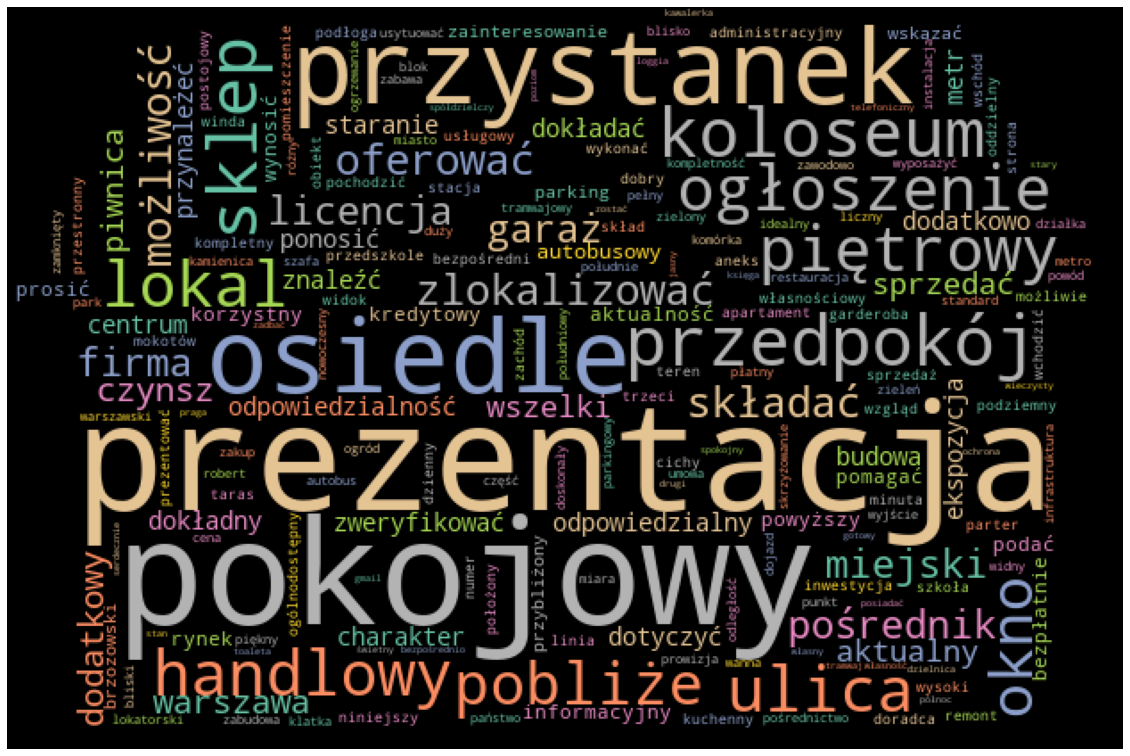

In [15]:

total_doc, gram_dict=get_n_grams(data,"opis_cleanv2")
plot_cloud(', '.join(total_doc))

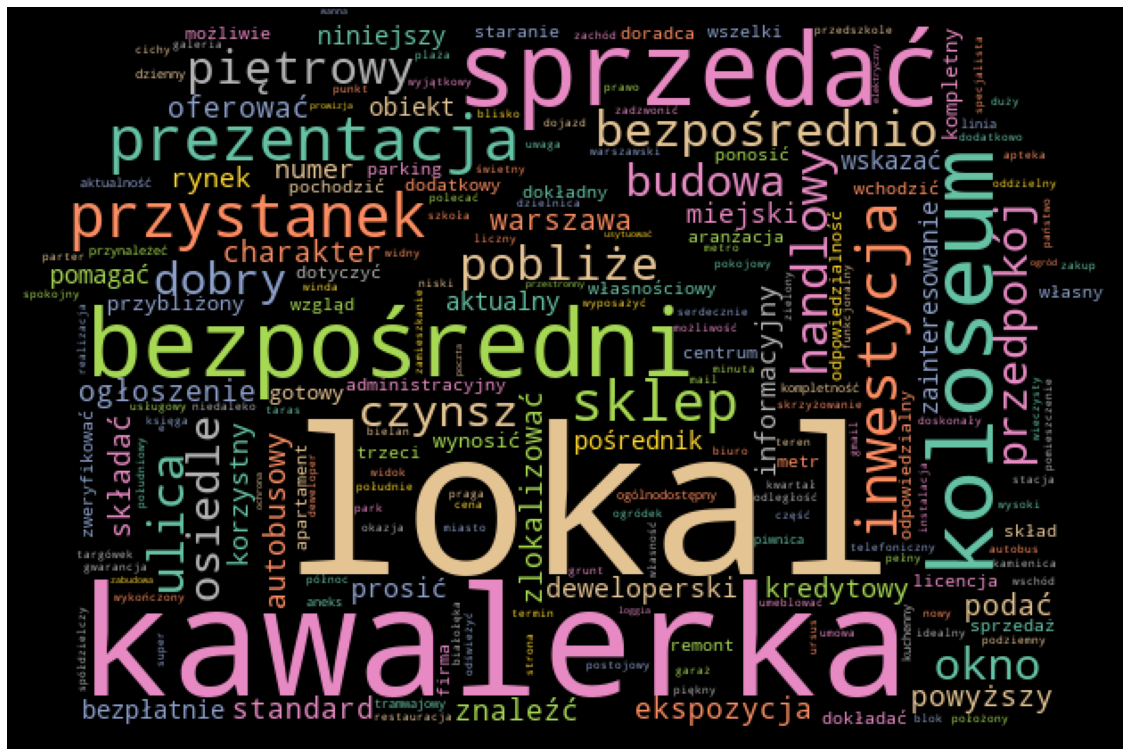

In [16]:
#Cheapest 5% wordcloud
cheapest_mask=data.cena.quantile(0.05)
cheapest_data=data[data.cena<= cheapest_mask]
cheapest_data.reset_index(inplace=True,drop=True)
#cheapest_data
total_doc, gram_dict=get_n_grams(cheapest_data,"opis_cleanv2")
plot_cloud(', '.join(total_doc))

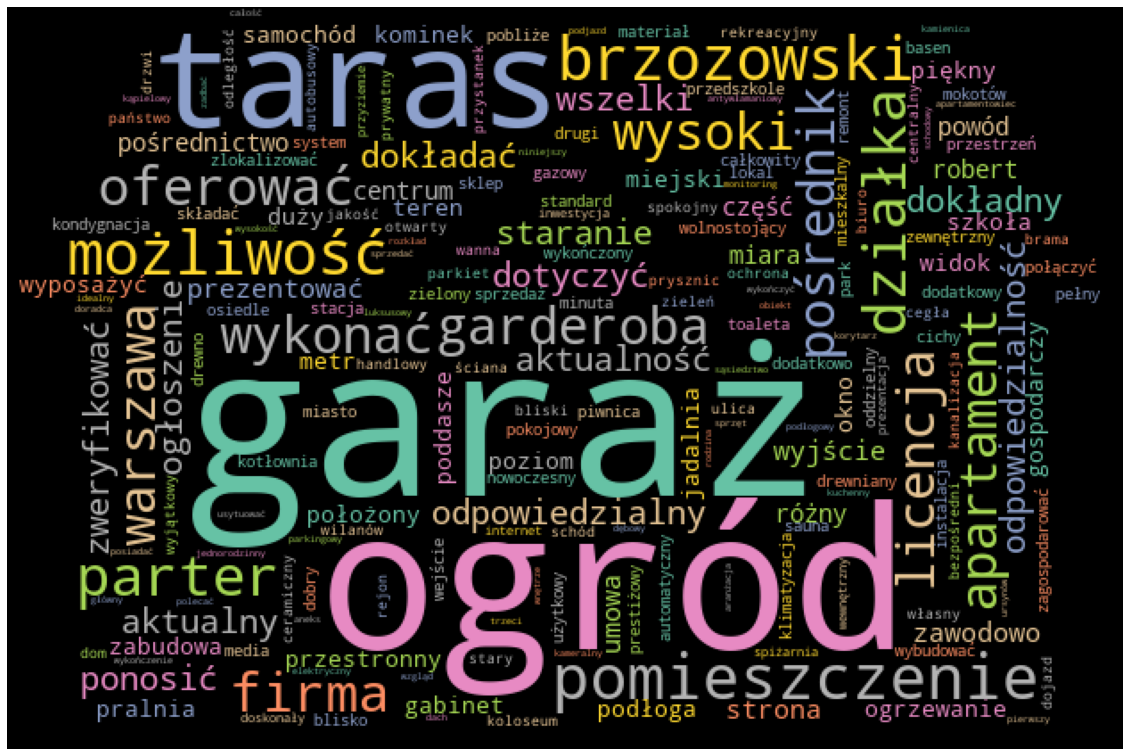

In [17]:
#Most expensive 5% wordcloud
expensive_mask=data.cena.quantile(0.95)
expensive_data=data[data.cena>= expensive_mask]
expensive_data.reset_index(inplace=True,drop=True)
#expensive_data
total_doc, gram_dict=get_n_grams(expensive_data,"opis_cleanv2_nlp")
plot_cloud(', '.join(total_doc))

In [18]:

#     tfidfvectorizer = TfidfVectorizer(min_df=0.02, max_df=.90)
#     tfidf_wm = tfidfvectorizer.fit_transform(cheapest_data['opis_cleanv2_nlp'])
#     sorted(zip( tfidfvectorizer.get_feature_names(),tfidfvectorizer.idf_), key=itemgetter(1), reverse=True)

In [19]:
# tfIdfVectorizer=TfidfVectorizer(smooth_idf=True,min_df=0.02, max_df=.90)
# tfIdf = tfIdfVectorizer.fit_transform(expensive_data['opis_cleanv2_nlp'])
# df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
# df = df.sort_values('TF-IDF', ascending=False)
# df.head(30)